In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import geopandas as gp
from collections import defaultdict

In [2]:
mat_contents = loadmat("../../graph_convolutional_clustering/data/wiki.mat")

In [3]:
mat_contents

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Feb 16 19:08:56 2019',
 '__version__': '1.0',
 '__globals__': [],
 'fea': <2405x4973 sparse matrix of type '<class 'numpy.float64'>'
 	with 1556595 stored elements in Compressed Sparse Column format>,
 'gnd': array([[9],
        [9],
        [9],
        ...,
        [9],
        [9],
        [9]], dtype=uint8),
 'W': <2405x2405 sparse matrix of type '<class 'numpy.float64'>'
 	with 24357 stored elements in Compressed Sparse Column format>}

In [4]:
mat_contents["W"].shape
mat_contents["fea"].shape

(2405, 4973)

In [8]:
np.unique(mat_contents["gnd"])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
      dtype=uint8)

In [5]:
def calculate_adjacency(gdf, unique_col):
    '''
    Code that takes a geodataframe and returns two dataframes: the first with rook adjacencies and the second with queen adjacencies.
    
    Both dataframes have two columns the first column with the unique column values, and the second column with a list of adjacent geometries, listed by their unique column value.
    ''' 
    
    # Confirm that unique_col is actually unique
    if not(max(gdf[unique_col].value_counts(dropna = False) == 1)):
        raise ValueError("Non-unique column provided")
    
    # Intersected the GeoDataFrame with the buffer with the original GeoDataFrame
    all_intersections = gp.overlay(gdf, gdf, how = "intersection", keep_geom_type = False)
   
    # Filter out self-intersections
    filtered_intersections = all_intersections[all_intersections[unique_col+"_1"]!=all_intersections[unique_col+"_2"]]
    
    # Separate out point intersections
    point_intersections = filtered_intersections[filtered_intersections.geom_type == "Point"]
    non_point_intersections = filtered_intersections[filtered_intersections.geom_type != "Point"]
    
    # Define a tuple of zips of the unique_col pairs present in the non-point intersections
    non_point_intersections_tuples = tuple(zip(non_point_intersections[unique_col+"_1"], non_point_intersections[unique_col+"_2"]))
    
    # Define a dictionary that will map from a unique_col value to a list of other unique_cols it is adjacent to
    rook_dict = defaultdict(list)
    
    # Iterate over the tuples
    for val in non_point_intersections_tuples:        
        rook_dict[val[0]].append(val[1])

    # Some shapes will only intersect with themselves and not be added to the above
    not_added = list(set(gdf[unique_col]).difference(set(rook_dict.keys())))
    for val in not_added:
        
        # For each of these, add a blank list to the dictionary
        rook_dict[val] = []
     
    # Create DataFrame of rook intersections
    df_rook = pd.DataFrame()
    df_rook['GEOID20'] = rook_dict.keys()
    df_rook["ADJ_GEOMS"] = rook_dict.values()

    return df_rook

In [12]:
df = gp.read_file("../joined_data/WIct.shp")

<AxesSubplot:>

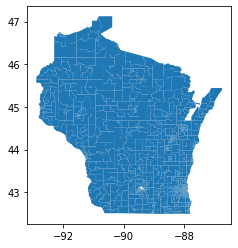

In [14]:
df.plot()

In [8]:
df["geometry"].sindex

rtree.index.Index(bounds=[-92.889433, 42.491912, -86.750119, 47.124928], size=70)

In [9]:
rook = calculate_adjacency(df,"GEO_ID")

In [10]:
rook.sort_values()

,GEOID20,ADJ_GEOMS
0,55001950202,"[55001950100, 55057100100, 55137960400, 550019..."
1,55057100100,"[55001950100, 55001950202, 55141010900, 550571..."
2,55097961200,"[55001950100, 55137960300, 55141011600, 550979..."
3,55137960300,"[55001950100, 55097961200, 55137960400, 551379..."
4,55141010900,"[55001950100, 55057100100, 55141011600, 551410..."
...,...,...
1387,55139001000,"[55139001200, 55139000700, 55139000800, 551390..."
1388,55139001100,"[55139001200, 55139001000, 55139001803, 551390..."
1389,55139001300,"[55139001200, 55139001500, 55139001100, 551390..."
1390,55139000800,"[55139000400, 55139000700, 55139000900, 551390..."


In [11]:
df

,GEO_ID,NAME_x,DP03_0001E,DP03_0001P,DP03_0002E,DP03_0002P,DP03_0003E,DP03_0003P,DP03_0004E,DP03_0004P,...,GEOID,NAME_y,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,55001950100,"Census Tract 9501, Adams County, Wisconsin",2631,2631,1249,47.5,1249,47.5,1184,45.0,...,55001950100,9501,Census Tract 9501,G5020,S,233951801,17547549,+44.2022742,-089.7468898,"POLYGON ((-89.92702 44.19367, -89.92679 44.194..."
1,55001950201,"Census Tract 9502.01, Adams County, Wisconsin",1349,1349,765,56.7,765,56.7,663,49.1,...,55001950201,9502.01,Census Tract 9502.01,G5020,S,110142594,7642055,+44.0031471,-089.8876764,"POLYGON ((-90.01877 44.04772, -90.01870 44.048..."
2,55001950202,"Census Tract 9502.02, Adams County, Wisconsin",2339,2339,1179,50.4,1168,49.9,1056,45.1,...,55001950202,9502.02,Census Tract 9502.02,G5020,S,467891428,50528185,+44.0888085,-089.7705744,"POLYGON ((-90.02638 44.08721, -90.02627 44.089..."
3,55001950400,"Census Tract 9504, Adams County, Wisconsin",3937,3937,2096,53.2,2093,53.2,1901,48.3,...,55001950400,9504,Census Tract 9504,G5020,S,235590227,1195071,+43.9407474,-089.7376994,"POLYGON ((-89.93773 43.96629, -89.93738 43.966..."
4,55001950501,"Census Tract 9505.01, Adams County, Wisconsin",1303,1303,676,51.9,676,51.9,614,47.1,...,55001950501,9505.01,Census Tract 9505.01,G5020,S,114019282,19754029,+43.8817191,-089.8962390,"POLYGON ((-89.98419 43.91181, -89.98397 43.913..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,55141011300,"Census Tract 113, Wood County, Wisconsin",3591,3591,2144,59.7,2144,59.7,2019,56.2,...,55141011300,113,Census Tract 113,G5020,S,12013212,1425599,+44.3643651,-089.8372719,"POLYGON ((-89.85937 44.36194, -89.85928 44.362..."
1388,55141011400,"Census Tract 114, Wood County, Wisconsin",4443,4443,2415,54.4,2415,54.4,2187,49.2,...,55141011400,114,Census Tract 114,G5020,S,11657150,341824,+44.3673095,-089.8033856,"POLYGON ((-89.81719 44.38606, -89.81718 44.386..."
1389,55141011500,"Census Tract 115, Wood County, Wisconsin",4793,4793,3386,70.6,3373,70.4,3208,66.9,...,55141011500,115,Census Tract 115,G5020,S,33527893,605288,+44.3654643,-089.7591255,"POLYGON ((-89.80564 44.34373, -89.80245 44.347..."
1390,55141011600,"Census Tract 116, Wood County, Wisconsin",4209,4209,2746,65.2,2746,65.2,2514,59.7,...,55141011600,116,Census Tract 116,G5020,S,128689803,4188672,+44.2849618,-089.7980036,"POLYGON ((-89.91256 44.27344, -89.91253 44.273..."
